In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import paths
import povray
import pandas as pd
from saapy.analysis import *
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pylab as pylab
matplotlib.style.use('ggplot')
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [50]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
pv = povray.Povray('../../../3party')
ent_frame = pd.read_csv(pv.analysis_dir_path / 'entities.csv')
lexeme_parser = LexemeParser()

In [5]:
metrics_frame = ent_frame.drop(['name', 'defs', 'kindname', 'longname'], axis=1)

In [6]:
lexeme_frame = ent_frame[['name', 'defs']]
parsed_lexemes = lexeme_parser.parse_lexeme_frame(lexeme_frame)
miss_frame = misses_to_frame(parsed_lexemes)
miss_frame.to_csv(pv.analysis_dir_path / 'lexeme-misses.csv', index=True)
print('manually edit terms in', pv.analysis_dir_path / 'lexeme-misses.csv', 'before executing next cell')

manually edit terms in /Users/ashapoch/Projects/3party/povray-analysis/lexeme-misses.csv before executing next cell


In [7]:
term_frame = pd.read_csv(pv.analysis_dir_path / 'lexeme-misses.csv')
term_frame = term_frame.drop(['lexemes'], axis=1).set_index('miss')
term_frame.head()

,term
miss,
01,01
a,a
aa,aa
adc,adc
alloc,alloc


In [8]:
terms = term_frame.to_dict()['term']
lexeme_parser.add_terms(terms)
parsed_lexemes = lexeme_parser.parse_lexeme_frame(lexeme_frame)
flattened_lexemes = flatten_lexeme_series(parsed_lexemes, skip_miss=False)
flattened_lexemes.head()

0    generic messenger generic messenger generic me...
1    I stream I stream I stream I stream read byte ...
2    O stream O stream O stream see kg tel lg clear...
3    I mem stream I mem stream read byte un read by...
4    gamma curve get lookup table is neutral encode...
dtype: object

In [9]:
flattened_lexemes.to_csv(pv.analysis_dir_path / 'flat-lexemes.csv', index=False, header=False)

In [10]:
entity_sentences = LineSentence(str(pv.analysis_dir_path / 'flat-lexemes.csv'))
entity_dict = Dictionary(entity_sentences)
entity_dict.filter_extremes(no_below=10, no_above=0.4)
entity_dict.compactify()
entity_dict.save(str(pv.analysis_dir_path / 'entity.dict'))
# entity_dict.load(str(pv.analysis_dir_path / 'entity.dict'))
entity_dict.save_as_text(str(pv.analysis_dir_path / 'entity.dict.txt'))

In [11]:
def bow_generator(filepath, entity_dict):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    
    for sentence in LineSentence(filepath):
        yield entity_dict.doc2bow(sentence)

In [12]:
# generate bag-of-words representations for
# all entities and save them as a matrix
MmCorpus.serialize(str(pv.analysis_dir_path / 'flat-lexemes.mm'),
                   bow_generator(str(pv.analysis_dir_path / 'flat-lexemes.csv'), entity_dict))
    
# load the finished bag-of-words corpus from disk
bow_corpus = MmCorpus(str(pv.analysis_dir_path / 'flat-lexemes.mm'))

In [13]:
lda = LdaMulticore(bow_corpus, num_topics=5,
                   id2word=entity_dict, workers=3)
lda.save(str(pv.analysis_dir_path / 'flat-lexemes.lda'))
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, bow_corpus, entity_dict)

In [14]:
pyLDAvis.display(LDAvis_prepared)

In [15]:
metrics_frame.head()

,AltAvgLineBlank,AltAvgLineCode,AltAvgLineComment,AltCountLineBlank,AltCountLineCode,AltCountLineComment,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,...,MaxCyclomaticStrict,MaxEssential,MaxInheritanceTree,MaxNesting,PercentLackOfCohesion,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential
0,2,9,0,62,201,13,1,1,1,1,...,3,1,0,2,60,0.06,30,30,30,18
1,0,2,0,4,23,5,1,1,1,1,...,1,1,1,0,0,0.22,6,6,6,6
2,0,9,0,11,108,9,3,3,3,1,...,12,1,1,4,18,0.08,30,30,33,10
3,0,10,0,13,135,3,2,2,2,1,...,11,6,2,3,65,0.02,31,29,32,16
4,0,6,1,38,134,187,2,2,2,1,...,6,4,0,3,91,1.48,40,40,41,20


In [16]:
metrics_frame.columns

Index(['AltAvgLineBlank', 'AltAvgLineCode', 'AltAvgLineComment',
       'AltCountLineBlank', 'AltCountLineCode', 'AltCountLineComment',
       'AvgCyclomatic', 'AvgCyclomaticModified', 'AvgCyclomaticStrict',
       'AvgEssential', 'AvgLine', 'AvgLineBlank', 'AvgLineCode',
       'AvgLineComment', 'CountClassBase', 'CountClassCoupled',
       'CountClassDerived', 'CountDeclClassMethod', 'CountDeclClassVariable',
       'CountDeclInstanceMethod', 'CountDeclInstanceVariable',
       'CountDeclInstanceVariablePrivate',
       'CountDeclInstanceVariableProtected', 'CountDeclInstanceVariablePublic',
       'CountDeclMethod', 'CountDeclMethodAll', 'CountDeclMethodConst',
       'CountDeclMethodFriend', 'CountDeclMethodPrivate',
       'CountDeclMethodProtected', 'CountDeclMethodPublic', 'CountLine',
       'CountLineBlank', 'CountLineCode', 'CountLineCodeDecl',
       'CountLineCodeExe', 'CountLineComment', 'CountLineInactive',
       'CountLinePreprocessor', 'CountStmt', 'CountStmtDecl', 'Co

In [17]:
mf = metrics_frame[['CountLineCode', 'AvgEssential', 'MaxEssential', 'MaxNesting', 'PercentLackOfCohesion', 'SumEssential']]

In [18]:
mf.head()

,CountLineCode,AvgEssential,MaxEssential,MaxNesting,PercentLackOfCohesion,SumEssential
0,201,1,1,2,60,18
1,23,1,1,0,0,6
2,108,1,1,4,18,10
3,135,1,6,3,65,16
4,126,1,4,3,91,20


In [19]:
mf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 6 columns):
CountLineCode            266 non-null int64
AvgEssential             266 non-null int64
MaxEssential             266 non-null int64
MaxNesting               266 non-null int64
PercentLackOfCohesion    266 non-null int64
SumEssential             266 non-null int64
dtypes: int64(6)
memory usage: 12.5 KB


In [20]:
from sklearn.linear_model import LogisticRegression

In [32]:
x_train = mf['CountLineCode'].to_frame()
y_train = mf['AvgEssential']

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
# Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(x_train, y_train) * 100, 2)
acc_log

86.090000000000003

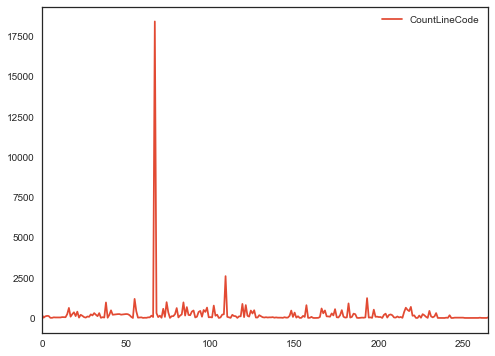

In [33]:
x_train.plot()

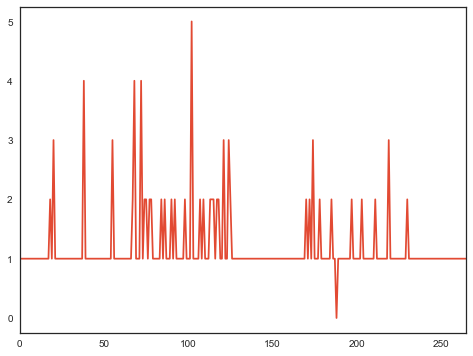

In [34]:
y_train.plot()

In [46]:
def plot_correlation_map(df, corr_method='spearman'):
    corr = df.corr(method=corr_method)
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

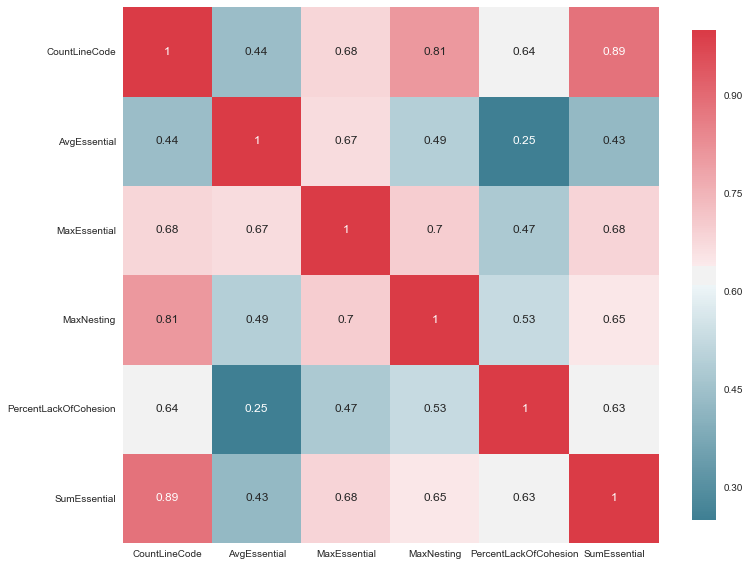

In [51]:
plot_correlation_map(mf)

In [104]:
c1s = pd.Series(['2017-04-02T11:22:44+02:00', '2017-04-03T11:21:44+02:00', '2017-04-02T11:22:44+02:00']) # pd.date_range(start='2017-01-01', periods=3)
c1 = pd.to_datetime(c1s, infer_datetime_format=True, utc=True)
c1[2] = c1[2] + pd.DateOffset(seconds=0.1)

In [113]:
pd.Timestamp('2017-04-02T11:22:44+02:00').astimezone(None)

Timestamp('2017-04-02 09:22:44')

In [105]:
c2 = {c1[0]: 1, c1[1]: 3}
c3 = {c1[1]: 'a', c1[2]: 'b', c1[0]: 'c'}
tdf = pd.DataFrame.from_dict(dict(c2=c2, c3=c3)).fillna(int(0))
tdf

,c2,c3
2017-04-02 09:22:44.000,1.0,c
2017-04-02 09:22:44.100,0.0,b
2017-04-03 09:21:44.000,3.0,a


In [87]:
tdf.index

DatetimeIndex(['2017-04-02 09:21:44', '2017-04-02 09:22:44',
               '2017-04-03 09:21:44'],
              dtype='datetime64[ns]', freq=None)

In [79]:
pv.load_git_graph()


  load_git_graph (/Users/ashapoch/Projects/ashapochka-github/saapy/samples/povray.py:46):
    0.756 seconds



In [80]:
pv.git_graph.commit_node(ref_name='origin/master')

{'author_tz_offset': -7200,
 'authored_date': 1491124904,
 'authored_datetime': '2017-04-02T11:21:44+02:00',
 'committed_date': 1491124904,
 'committed_datetime': '2017-04-02T11:21:44+02:00',
 'committer_tz_offset': -7200,
 'encoding': 'UTF-8',
 'gpgsig': None,
 'hexsha': '1e3b586b2fce101fd150748fcb4a426ac32e9fb9',
 'message': "Merge branch 'release/v3.7.1'\n",
 'name_rev': '1e3b586b2fce101fd150748fcb4a426ac32e9fb9 master',
 'node_type': 'commit',
 'parent_count': 2,
 'ref_head': True,
 'ref_name': 'origin/master',
 'stats_total_deletions': 20897,
 'stats_total_files': 202,
 'stats_total_insertions': 24543,
 'stats_total_lines': 45440,
 'summary': "Merge branch 'release/v3.7.1'"}

In [100]:
pd.DateOffset?